
# Maestria en Explotacion de datos y Descubrimiento de conocimiento

## Aprendizaje Automatico

## Trabajo Practico N°2

### Grupo:

* Adrian Marino
* Alejandro Szpak
* Claudio Collado

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# !sudo apt-get install sox

In [1]:
import sys
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Scikitlearn...

from sklearn.ensemble        import RandomForestClassifier, \
                                    AdaBoostClassifier, \
                                    GradientBoostingClassifier

from sklearn.model_selection import train_test_split, \
                                    RandomizedSearchCV, \
                                    LeaveOneGroupOut, \
                                    KFold


# Librerias propias..

from data   import  Dataset, exclude_columns

from metric import  plot_confusion_matrix, \
                    missing_values_summary, \
                    set_summary, \
                    show_score, \
                    show_cv_score

from sound  import  play, play_audio, \
                    get_functional_feats,\
                    create_new_file_with_noise

#### 1. Cargamos el dataset que ya generamos en la notebook **generar-dataset**.

Este csv representa a todos los archivos de ambos dataset(speechs y songs). La notebook **generar-dataset** descarga ambos datasets y los descompromirlo. Luego recorrer una lista de paths, uno por cada archivo de audio y genera un csv donde las columnas se extraen de la siguiente forma:

* Se toman los features que estan definitos en el nombre del archivo separados por el caracter **-**.
* Se usando la libreria opensmile. Esta extrace features del archivo de audio.

In [2]:
dataset = pd.read_csv('dataset.csv')

In [3]:
dataset.head()

,Unnamed: 0,actor,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,file,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0,23,./speech/Actor_23/03-01-04-02-01-01-23.wav,3,1,4,2,1,1,./speech/Actor_23/03-01-04-02-01-01-23.wav,...,0.044101,0.007548,0.015374,1.877934,1.425178,0.251667,0.247482,0.367143,0.419309,-39.951572
1,1,23,./speech/Actor_23/03-01-04-02-02-02-23.wav,3,1,4,2,2,2,./speech/Actor_23/03-01-04-02-02-02-23.wav,...,0.011092,0.008020,0.014090,1.694915,0.856531,0.357500,0.072241,0.634000,0.483429,-42.310856
2,2,23,./speech/Actor_23/03-01-06-02-01-02-23.wav,3,1,6,2,1,2,./speech/Actor_23/03-01-06-02-01-02-23.wav,...,0.101003,0.014311,0.014765,2.339181,0.593472,0.635000,0.335000,0.683333,0.449024,-34.312801
3,3,23,./speech/Actor_23/03-01-07-01-01-02-23.wav,3,1,7,1,1,2,./speech/Actor_23/03-01-07-01-01-02-23.wav,...,0.062009,0.011443,0.021647,2.528090,1.424501,0.180000,0.099800,0.416667,0.422834,-44.573288
4,4,23,./speech/Actor_23/03-01-03-01-01-02-23.wav,3,1,3,1,1,2,./speech/Actor_23/03-01-03-01-01-02-23.wav,...,0.032799,0.011666,0.009868,2.153846,0.625000,0.570000,0.320000,0.670000,0.452548,-36.173256


Audio de un speech:

In [4]:
play(dataset[dataset['vocal_channel'] == 1].iloc[0, :])

Audio Cantado:

In [5]:
play(dataset[dataset['vocal_channel'] == 2].iloc[0, :])

Quitamos columnas que no vamos usar como:

In [6]:
example_columns  = set(dataset.columns) - set([
    'Unnamed: 0',
    'file',
    'modality',
    'statement',
    'repetition',
    'start',
    'end'
])
target_column = 'emotion'

# Esta dos columnas se usan mas adelantes para hacer fold de los actores 
# y luego para agregar ruido a los audios.
special_columns = ['actor', 'file_path']

Luego codificamos **vocal_channel** como dummy y separamos en features de target:

In [7]:
dataset['vocal_channel'].value_counts()

1    1440
2    1012
Name: vocal_channel, dtype: int64

In [8]:
def features_target(df):
    df = df[example_columns]
    df['vocal_channel'] = pd.get_dummies(df['vocal_channel'])
    return exclude_columns(df, [target_column]),  df[[target_column]]

In [9]:
features, target = features_target(dataset)

In [10]:
features['vocal_channel'].value_counts()

1    1440
0    1012
Name: vocal_channel, dtype: int64

Analizamos si hay valores faltantes:

In [11]:
missing_values_summary(features)

Series([], dtype: float64)

Vemos que esta codificado el campo: 0 para speech y 1 para song.

Partimos en dev y test:

In [12]:
random_state = 1
test_size    = 0.3

In [13]:
X_dev, X_test, y_dev, y_test = train_test_split(
    features, 
    target, 
    test_size    = test_size, 
    stratify     = target, 
    random_state = random_state,
    shuffle      = True
)

A continuacion se muestra el porcentaje de ejemplos por clase y si hay valores faltantes:

In [14]:
set_summary(X_dev, y_dev)

- Features shape: (1716, 92)
- Target shape: (1716, 1)
- Target classes:
	- Clase '2': 15.33 %
	- Clase '3': 15.33 %
	- Clase '4': 15.33 %
	- Clase '5': 15.33 %
	- Clase '6': 15.33 %
	- Clase '7': 7.87 %
	- Clase '8': 7.81 %
- Valores faltantes en features: No hay valores faltantes!


In [15]:
set_summary(X_test, y_test)

- Features shape: (736, 92)
- Target shape: (736, 1)
- Target classes:
	- Clase '2': 15.35 %
	- Clase '3': 15.35 %
	- Clase '4': 15.35 %
	- Clase '5': 15.35 %
	- Clase '6': 15.35 %
	- Clase '8': 7.88 %
	- Clase '7': 7.74 %
- Valores faltantes en features: No hay valores faltantes!


#### 2. Ahora vamos a probar modelos con dos estrategias distintas de cross validation.

**Estrategia 1**: 12-fold cross validation armando los folds de forma aleatoria.

In [16]:
cv_strategy_1 = KFold(n_splits=12)

In [17]:
X_Dev_input = exclude_columns(X_dev, special_columns)

Random Forest:

In [18]:
show_cv_score(RandomForestClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.651 %


RandomForestClassifier()

Ada Boost:

In [19]:
show_cv_score(AdaBoostClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.363 %


AdaBoostClassifier()

Gradient Boosting:

In [20]:
%%time
show_cv_score(GradientBoostingClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 0.645 %
CPU times: user 15.8 ms, sys: 3.28 ms, total: 19.1 ms
Wall time: 20 s


GradientBoostingClassifier()

**Estrategia 2**: Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos.

La siguiente funcion toma todos los posibles valores de la columna especificada en **input_column** los agrupa en grupos de tamaño **group_size** y luego agrega uni nueva columna (**target_column**) donde se especifica cada fila a que grupo pertenese:

In [21]:
def sample_groups(X, column, group_size):
    numbers = X[column].unique()
    sample  = np.random.choice(numbers, size=len(numbers), replace=False)
    
    return sample.reshape((int(len(numbers) / group_size), group_size))

def set_groups(X, input_column, group_size, target_column):
    tmp = X.copy()

    index = int(max(X[input_column].unique())) + 1
    for group in sample_groups(X, input_column, group_size):
        tmp[target_column] = tmp[input_column].apply(lambda x: index if x in group else x)
        index += 1

    return tmp

In [22]:
sample_groups(X_dev, 'actor', 2)

array([[ 7, 23],
       [ 4, 11],
       [21, 18],
       [22,  6],
       [ 5, 13],
       [10,  1],
       [ 9,  2],
       [24, 19],
       [ 8, 16],
       [20, 17],
       [12, 15],
       [ 3, 14]])

In [23]:
X_dev_tmp = set_groups(
    X_dev, 
    input_column  = 'actor', 
    group_size    = 2, 
    target_column = 'actor'
)
actors_fold_input  = exclude_columns(X_dev_tmp, special_columns)
actors_fold_groups = X_dev_tmp['actor']

Nos quedan 12 grupos de 2 actores cada uno:

In [24]:
len(actors_fold_groups.unique())

12

In [25]:
cv_strategy_2 = LeaveOneGroupOut()

Random Forest:

In [26]:
show_cv_score(RandomForestClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.525 %


RandomForestClassifier()

Ada Boost:

In [27]:
show_cv_score(AdaBoostClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.365 %


AdaBoostClassifier()

Gradient Boosting:

In [28]:
%%time
show_cv_score(GradientBoostingClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 0.521 %
CPU times: user 19.5 ms, sys: 643 µs, total: 20.1 ms
Wall time: 20.2 s


GradientBoostingClassifier()

#### 3. Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

In [29]:
def randomized_search(
    model, 
    params_grid, 
    cv, 
    X, 
    y,
    groups  = None, 
    scoring = 'accuracy', 
    n_jobs  = 24, 
    n_iter  = 50, 
    verbose = 1, 
    return_train_score = True
):
    rs = RandomizedSearchCV(
        model,
        params_grid, 
        n_jobs  = n_jobs, 
        scoring = scoring,
        cv      = cv,
        n_iter  = n_iter,
        verbose = verbose,
        return_train_score  = return_train_score
    )
    rs.fit(X, y, groups=groups)
    return rs

In [30]:
X_test_without_special_columns = exclude_columns(X_test, special_columns)

Random Forest:

In [31]:
%%time

rs = randomized_search(
    model       = RandomForestClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'criterion': ['gini','entropy'],
        'max_depth': list(range(1, 30)),
        'ccp_alpha': np.linspace(0, 0.5, 100)
    }, 
)
random_forest = show_score(rs.best_estimator_, X_test_without_special_columns, y_test)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    7.9s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:   19.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:   28.5s finished


Accuracy: 59.239 %
CPU times: user 1.94 s, sys: 43.6 ms, total: 1.98 s
Wall time: 29.7 s


In [34]:
plot_decision_regions(X_test_without_special_columns.to_numpy(), y_test.to_numpy(), clf=random_forest, legend=2)

ValueError: y must be a 1D array. Found (736, 1)

Ada Boost:

In [34]:
%%time

rs = randomized_search(
    model       = AdaBoostClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : range(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    }
)
ada_boost = show_score(rs.best_estimator_, X_test_without_special_columns, y_test)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    4.4s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    6.1s finished


Accuracy: 41.576 %
CPU times: user 984 ms, sys: 33.8 ms, total: 1.02 s
Wall time: 6.48 s


Gradient Boosting:

In [35]:
%%time

rs = randomized_search(
    model       = GradientBoostingClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : range(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    } 
)
gradient_boosting = show_score(rs.best_estimator_, X_test_without_special_columns, y_test)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   26.6s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  1.0min
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:  1.5min finished


Accuracy: 59.918 %
CPU times: user 4.56 s, sys: 35.4 ms, total: 4.6 s
Wall time: 1min 34s


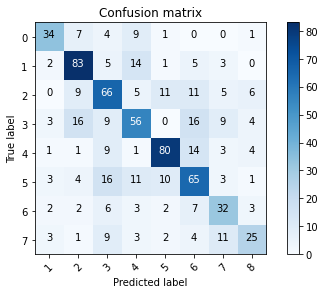

In [36]:
y_pred = gradient_boosting.predict(X_test_without_special_columns)
plot_confusion_matrix(y_test, y_pred)

In [37]:
man_actors   = [x for x in features['actor'].unique() if x % 2 == 0]
woman_actors = [x for x in features['actor'].unique() if x % 2 != 0]

In [38]:
def filter_set(X, y, column, values): return X[X[column].isin(values)], y[X[column].isin(values)]

speechs_features, speechs_y_true = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [0])
songs_features,   songs_y_true   = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [1])

speechs_features, speechs_y_true = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [0])
songs_features,   songs_y_true   = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [1])

man_features, man_y_true     = filter_set(X_test, y_test, 'actor', man_actors)
woman_features, woman_y_true = filter_set(X_test, y_test, 'actor', woman_actors)

man_features = exclude_columns(man_features, special_columns)
woman_features = exclude_columns(woman_features, special_columns)

Audios Cantados vs Hablados:

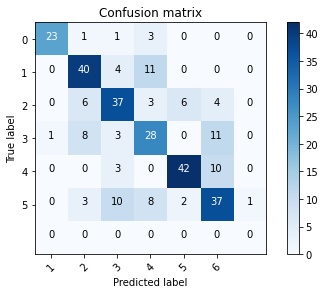

Accuracy: 67.647 %


GradientBoostingClassifier(learning_rate=0.18, n_estimators=18)

In [39]:
y_pred = gradient_boosting.predict(speechs_features)

plot_confusion_matrix(speechs_y_true, y_pred)
show_score(gradient_boosting, speechs_features, speechs_y_true)

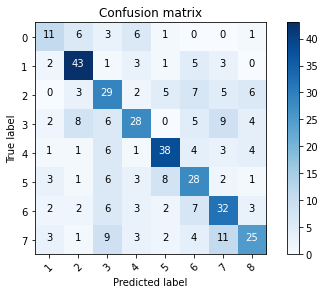

Accuracy: 54.419 %


GradientBoostingClassifier(learning_rate=0.18, n_estimators=18)

In [40]:
y_pred = gradient_boosting.predict(songs_features)

plot_confusion_matrix(songs_y_true, y_pred)
show_score(gradient_boosting, songs_features, songs_y_true)

Audios de  voces feneninas vs masculinas:

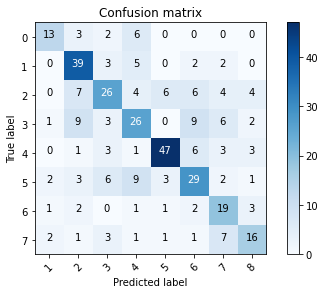

Accuracy: 58.424 %


GradientBoostingClassifier(learning_rate=0.18, n_estimators=18)

In [41]:
y_pred = gradient_boosting.predict(woman_features)

plot_confusion_matrix(woman_y_true, y_pred)
show_score(gradient_boosting, woman_features, woman_y_true)

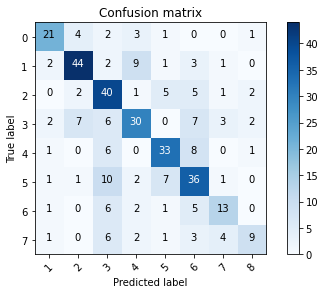

Accuracy: 61.413 %


GradientBoostingClassifier(learning_rate=0.18, n_estimators=18)

In [42]:
y_pred = gradient_boosting.predict(man_features)

plot_confusion_matrix(man_y_true, y_pred)
show_score(gradient_boosting, man_features, man_y_true)

#### 4. Evaluar la robustez del mejor modelo ante la presencia de ruido en los audios. Realizar una curva que muestre cómo varía una métrica de desempeño para distintas relaciones señal a ruido. El ruido utilizado puede ser sintético (gaussiano por ejemplo), o ruido ambiental. Algunas fuentes de ruido ambiental son:

Comparemos un ejemplo sin ruido contra otro con cierto nivel de ruido:

In [43]:
example_path = X_test['file_path'].values[0]
play_audio(example_path)

Para agregar ruido al audio usamos la funcion **create_new_file_with_noise**. Esta funcion agrega ruido al audio usando la relacion senal ruido(SNR):

In [44]:
noise_example_path = create_new_file_with_noise(example_path, level = 10 ** -4)

print(noise_example_path)
play_audio(noise_example_path)

./speech/Actor_07/noisy/d8e90df8-d204-11eb-bdce-5b54a9f9e347-03-01-03-02-01-02-07.wav


Redefinimos la funcion que extrae los features de cada audio. Esta nueva funcion agregar ruido al audio antes de extraer sus features.

In [45]:
def feature_extraction_with_noise(file_path, noise_level):
    if noise_level > 0:
        file_path = create_new_file_with_noise(file_path, noise_level)
    return get_functional_feats(file_path)

Comparemos los features con y sin ruido:

In [46]:
feature_extraction_with_noise(noise_example_path, noise_level = 0.0005)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_07/noisy/noisy/d8eea56a-d204-11...,0 days,0 days 00:00:04.037354167,37.479046,0.057176,35.862835,37.472813,39.376331,3.513496,30.805414,...,0.013312,0.00008,0.405044,2.238806,2.015113,0.14125,0.082377,0.296667,0.399861,-28.126013


In [47]:
feature_extraction_with_noise(noise_example_path, noise_level = 0)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_07/noisy/d8e90df8-d204-11eb-bdc...,0 days,0 days 00:00:04.037354167,36.843426,0.076832,35.571953,37.022415,39.368645,3.796692,111.791298,...,0.014886,0.003333,0.119081,2.487562,1.763224,0.22,0.090396,0.324286,0.438141,-30.70797


A continuacion vamos a probar cada uno de los modelos del punto 3 evaluandolos en el conjunto de test e inyectando distintos niveles de ruido. De esta manera podemos compara como se comporta cada modelo ante la presencia de ruido. La funcion **plot_noise_vs_accuracy_curve** entrena el modelo para distintos niveles de ruido y grafica cada nivel de ruido vs accuracy.

In [48]:
def generate_noisy_features(example_paths, noise_level):
    examples = Dataset().search_by_paths(
        example_paths, 
        feature_extract_fn = lambda file_path: feature_extraction_with_noise(file_path, noise_level)
    )
    
    X, y = features_target(examples)
    X = exclude_columns(X, special_columns)

    return X, y

def noise_vs_accuracy_metrics(models, example_paths, y_test, noise_levels):
    accuracy = {i:[] for i in range(0, len(models)) }

    for noise_level in noise_levels:
        X_noise, _ = generate_noisy_features(example_paths, noise_level)
        y_true     = y_test.iloc[X_noise.index.values, :]

        for i, model in enumerate(models):
            acc = model.score(X_noise, y_true)
            accuracy[i].append(acc)
            print('Model: {}, SNR: {}, Accuracy: {:.2f} %'.format(i, noise_level, acc * 100))

    return noise_levels, accuracy

In [65]:
noise_levels = [0] + [10 ** -v for v in range(30, 0, -10)] + [10 ** -v for v in range(10, -1, -2)]
noise_levels

[0, 1e-30, 1e-20, 1e-10, 1e-10, 1e-08, 1e-06, 0.0001, 0.01, 1]

In [66]:
test_example_paths = X_test['file_path'].unique()

Realizamos la grafica SNR vs Accuracy usando el conjunto de test:

In [67]:
noise_levels, accuracy = noise_vs_accuracy_metrics(
    [random_forest, ada_boost, gradient_boosting],
    test_example_paths, 
    y_test, 
    noise_levels
)

  0%|          | 1/736 [00:00<01:35,  7.73it/s]

Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: 0, SNR: 0, Accuracy: 59.92 %
Model: 1, SNR: 0, Accuracy: 41.58 %
Model: 2, SNR: 0, Accuracy: 59.92 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: 0, SNR: 1e-30, Accuracy: 18.58 %
Model: 1, SNR: 1e-30, Accuracy: 16.26 %
Model: 2, SNR: 1e-30, Accuracy: 18.99 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: 0, SNR: 1e-20, Accuracy: 18.58 %
Model: 1, SNR: 1e-20, Accuracy: 16.26 %
Model: 2, SNR: 1e-20, Accuracy: 18.99 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: 0, SNR: 1e-10, Accuracy: 19.26 %
Model: 1, SNR: 1e-10, Accuracy: 16.39 %
Model: 2, SNR: 1e-10, Accuracy: 18.99 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: 0, SNR: 1e-10, Accuracy: 19.26 %
Model: 1, SNR: 1e-10, Accuracy: 16.26 %
Model: 2, SNR: 1e-10, Accuracy: 19.26 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: 0, SNR: 1e-08, Accuracy: 19.67 %
Model: 1, SNR: 1e-08, Accuracy: 16.39 %
Model: 2, SNR: 1e-08, Accuracy: 19.40 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: 0, SNR: 1e-06, Accuracy: 19.40 %
Model: 1, SNR: 1e-06, Accuracy: 17.62 %
Model: 2, SNR: 1e-06, Accuracy: 18.85 %
Dataset alredy downloaded!


  0%|          | 2/736 [00:00<01:04, 11.36it/s]

Model: 0, SNR: 0.0001, Accuracy: 19.40 %
Model: 1, SNR: 0.0001, Accuracy: 17.76 %
Model: 2, SNR: 0.0001, Accuracy: 18.85 %
Dataset alredy downloaded!


  0%|          | 2/736 [00:00<01:04, 11.43it/s]

Model: 0, SNR: 0.01, Accuracy: 15.30 %
Model: 1, SNR: 0.01, Accuracy: 16.39 %
Model: 2, SNR: 0.01, Accuracy: 11.89 %
Dataset alredy downloaded!


100%|██████████| 736/736 [01:07<00:00, 10.86it/s]

Model: 0, SNR: 1, Accuracy: 15.30 %
Model: 1, SNR: 1, Accuracy: 15.30 %
Model: 2, SNR: 1, Accuracy: 11.61 %


In [78]:
def plot_metrics(noise_levels, accuracy, model_names):
    sns.set_style("white")
    sns.despine()
    sns.set(rc={'figure.figsize':(20, 10)})
    for number in accuracy:
        sns.lineplot(
            noise_levels, 
            accuracy[number], 
            label=model_names[number]
        )

    plt.xlabel('SNR')
    plt.ylabel('Accuracy')
    plt.show()

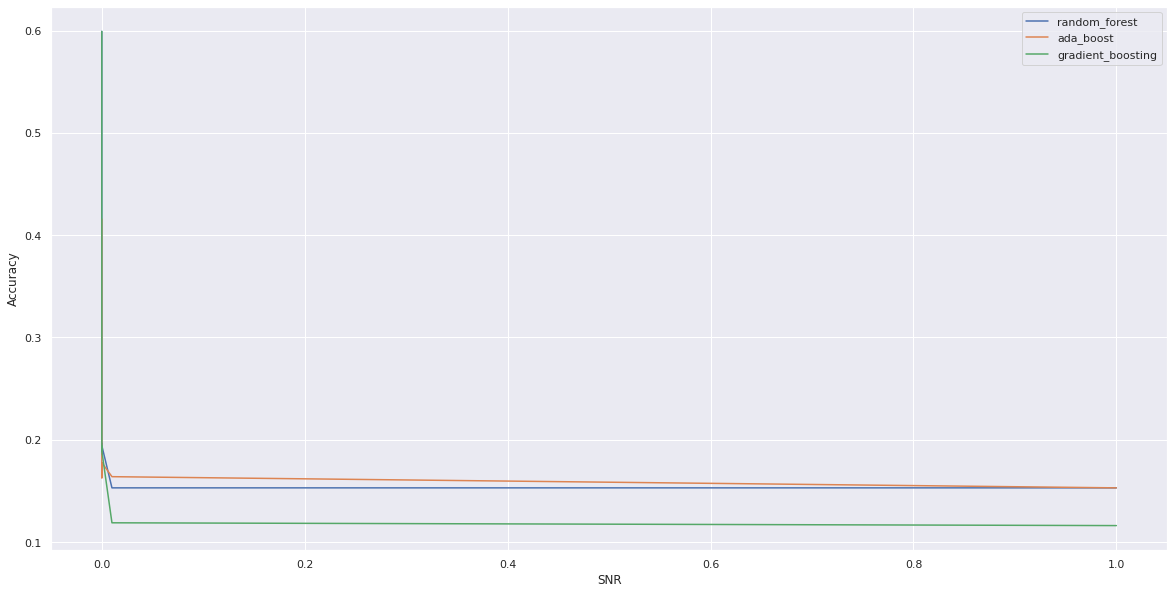

In [79]:
plot_metrics(
    noise_levels, 
    accuracy, 
    model_names = ['random_forest', 'ada_boost', 'gradient_boosting']
)